In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/CIS581/ESE360_Final

/content/drive/MyDrive/Colab Notebooks/CIS581/ESE360_Final


In [ ]:
import numpy as np
import os
from math import * 
from matplotlib import pyplot as plt
import copy
import tensorflow as tf

In [ ]:
data_dir = 'DATASET/'

In [ ]:
def read_data(filename):
  data = []
  file = open(data_dir + filename)
  for line in file:
    str_list = line.split(',')
    data.append([float(x) for x in str_list])
  return np.array(data)

In [ ]:
def plot_data(data, title):
  x = np.arange(0, len(data)) 
  plt.title(title) 
  plt.xlabel("Samples over time") 
  plt.ylabel("IMU Readings") 
  plt.plot(x, data) 
  plt.show()

def plot_data_more(dataX, dataY, dataZ, title):
  x = np.arange(0, len(dataX)) 
  plt.title(title) 
  plt.xlabel("Samples over time") 
  plt.ylabel("IMU Readings") 
  plt.plot(x, dataX, label = "x") 
  plt.plot(x, dataY, label = "y") 
  plt.plot(x, dataZ, label = "z") 
  plt.legend()
  plt.show()

def plot_data2(normal, average, title):
  xn = np.arange(0, len(normal)) 
  xa = np.arange(0, len(average)) 
  plt.title(title) 
  plt.xlabel("Samples over time") 
  plt.ylabel("IMU Readings") 
  plt.plot(xn, normal, label = "normal") 
  plt.plot(xa, average, label = "anom") 
  plt.legend()
  plt.show()

In [ ]:
def remove_noise(data, num):
  pad = data[-1]
  new_data = copy.deepcopy(data)
  for i in range(1, num + 1):
    a = [pad] * i
    to_add = np.array(new_data.tolist() + a)
    new_data = new_data + to_add[i:]
  return (new_data / (num + 1)).astype(np.int16)

def remove_noise2(data, num):
  new_data = remove_noise(data, 1)
  
  for i in range(num):
    new_data = remove_noise(new_data, 1)
  return new_data

def feature_extraction(data, j):
  new_data = []
  i = 0
  while i <= (len(data) - j):
    newPt = 0
    for k in range(j):
      newPt +=data[i + k]
    new_data.append(newPt / j)
    i += j
  return np.array(new_data)

def total_fe(data):
  d1 = feature_extraction(data, 2)
  return d1
  return remove_noise(d1, 4)


In [ ]:
def clean_dataset(dataset):
  new = []
  for d in dataset:
    new.append(total_fe(d))
  return np.array(new)

In [ ]:
bumps_dataset = read_data('GY_anom.txt')
bumps_dataset_cleaned = clean_dataset(bumps_dataset)
normal_dataset = read_data('GY_normal.txt')
normal_dataset_cleaned = clean_dataset(normal_dataset)


In [ ]:
train_dataset = normal_dataset_cleaned[16:]

test_norm_dataset = normal_dataset_cleaned[:16]
test_anom_dataset = bumps_dataset_cleaned
test_dataset = np.concatenate((test_anom_dataset, test_norm_dataset), axis=0)


In [ ]:
bumps_dataset_cleaned.shape

(16, 30)

In [ ]:
false_labels_list = np.zeros(shape=(test_anom_dataset.shape[0], ), dtype=bool)
true_labels_list = np.ones(shape=(test_norm_dataset.shape[0], ), dtype=bool)
test_labels_list = np.concatenate((false_labels_list, true_labels_list), axis=0)
train_labels_list = np.ones(shape=(train_dataset.shape[0], ), dtype=bool)

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(30,)),
                                    tf.keras.layers.Dense(2, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(30, activation=tf.nn.relu)])

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mae')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# OPT = 'adam'
# LOSS = 'binary_crossentropy'

# model.compile(optimizer= OPT,
#               loss= LOSS,
#               metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, train_dataset, epochs=1000)

Epoch 1/1000
2/2 [==============================] - 0s 5ms/step - loss: 14.3573
Epoch 2/1000
2/2 [==============================] - 0s 11ms/step - loss: 14.2544
Epoch 3/1000
2/2 [==============================] - 0s 7ms/step - loss: 14.1899
Epoch 4/1000
2/2 [==============================] - 0s 4ms/step - loss: 14.1393
Epoch 5/1000
2/2 [==============================] - 0s 4ms/step - loss: 14.1113
Epoch 6/1000
2/2 [==============================] - 0s 6ms/step - loss: 14.0756
Epoch 7/1000
2/2 [==============================] - 0s 6ms/step - loss: 14.0385
Epoch 8/1000
2/2 [==============================] - 0s 4ms/step - loss: 13.9963
Epoch 9/1000
2/2 [==============================] - 0s 8ms/step - loss: 13.9230
Epoch 10/1000
2/2 [==============================] - 0s 12ms/step - loss: 13.8404
Epoch 11/1000
2/2 [==============================] - 0s 4ms/step - loss: 13.7682
Epoch 12/1000
2/2 [==============================] - 0s 6ms/step - loss: 13.7328
Epoch 13/1000
2/2 [================

In [ ]:
reconstructions = model.predict(train_dataset)
train_loss = tf.keras.losses.mae(reconstructions, train_dataset)
threshold = np.mean(train_loss) + np.std(train_loss)
threshold

2/2 [==============================] - 0s 5ms/step


15.478666673828826

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

def predict(model, data, threshold):
    '''
    From the model and data, get your reconstructed data. Then calculate the MAE loss between the reconstrcuted data
    and original data. Then create a mask where loss < threshold

    
    input: 
        model - autoencoder model
        data  - test_data
        threshold - threshold

    output:
        preds - mask where loss is less than threshold



    '''


    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    preds =  tf.math.less(loss, threshold)
    print(preds)



    return preds



def print_stats(predictions, labels):
    '''
    Given the predictions and labels, print the Accuracy, Precision, and Recall scores.

    input:
        predictions - mask of predictions containing True and False values
        labels      - test_labels containing 1s and 0s

    output:
        None

    '''

    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(model, train_dataset, 16.01)
print_stats(preds, train_labels_list)

tf.Tensor(
[False  True  True False False  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True], shape=(34,), dtype=bool)
Accuracy = 0.8529411764705882
Precision = 1.0
Recall = 0.8529411764705882


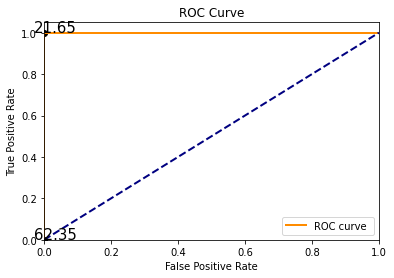

In [ ]:
reconstructions = model(test_dataset)
loss = tf.keras.losses.mae(reconstructions, test_dataset)
fpr = []     # false positive
tpr = []     # true positive

# the test labels are flipped to match how the roc_curve function expects them.
flipped_labels = 1 - test_labels_list 
fpr, tpr, thresholds = roc_curve(flipped_labels, loss)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# plot some thresholds
thresholds_every=2
thresholdsLength = len(thresholds)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, thresholds_every):
  threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
  plt.scatter(fpr[i], tpr[i], c='black')
  plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15});

plt.show()


In [ ]:
preds = predict(model, test_dataset, 22)
print_stats(preds, test_labels_list)

tf.Tensor(
[False False False False False False False False False False False  True
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True], shape=(32,), dtype=bool)
Accuracy = 0.96875
Precision = 0.9411764705882353
Recall = 1.0


In [ ]:
SAVED_MODEL_FILENAME = "original"
FLOAT_TFL_MODEL_FILENAME = "float.tfl"
QUANTIZED_TFL_MODEL_FILENAME =  "quant.tfl"
TFL_CC_MODEL_FILENAME = "micro.cc"

In [ ]:
model.save(SAVED_MODEL_FILENAME)

In [ ]:
np.amax(bumps_dataset_cleaned)

274.6275

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_tflite = converter.convert()
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_tflite)

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

5024

In [ ]:
def predict_tflite(tflite_model, data, thresh):

  # Initialize the TFLite interpreter 
  ### ENTER CODE BELOW
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  ### ENTER CODE ABOVE
  
  input_details = interpreter.get_input_details()[0]
  print(input_details)
  output_details = interpreter.get_output_details()[0]
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], [data])
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
    

  ### ENTER CODE ABOVE
  return pred

In [ ]:
predict_tflite(model_tflite, test_dataset[20].astype(np.float32), 0.5)

{'name': 'serving_default_dense_4_input:0', 'index': 0, 'shape': array([ 1, 30], dtype=int32), 'shape_signature': array([-1, 30], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


array([ 0.      ,  0.      ,  0.      , 10.272315,  0.      ,  0.      ,
       17.220785,  9.620763,  8.568839,  0.      ,  0.      , 16.289278,
       21.292858,  0.      ,  0.      ,  0.      , 17.412985,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      , 15.331062,  0.      ,
        0.      , 12.464388,  0.      ,  0.      ,  0.      ,  0.      ],
      dtype=float32)

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

In [ ]:
!cat {TFL_CC_MODEL_FILENAME}


unsigned char g_magic_wand_model_data[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0xf8, 0x0c, 0x00, 0x00,
  0x08, 0x0d, 0x00, 0x00, 0x4c, 0x13, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x37, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 